In [20]:
import pandas as pd
from glob import glob
import os
import json

output_csv_name = "cse641_attendance.csv"
input_csv_name =  "cse641_student_list.csv"
output_json_name = "cse641_attendance.json"

# Paths
att_path = r"E:\code\DL_ClassFR\RECORDS\before_midsem_photo"
input_csv = os.path.join(att_path, input_csv_name) 
output_csv = os.path.join(att_path, output_csv_name) 

# ALL STUDENTS AVAILABLE FOR ATTENDANCE
df = pd.read_csv(input_csv) # Load existing CSV with roll numbers and dates
df.set_index("Roll No", inplace=True)
df.index = df.index.astype(str).str.upper() # Normalize roll numbers to string and uppercase for comparison

# Process each attendance file
att_files = glob(f"{att_path}/pred_*.csv")
for att_file in att_files:
    # Extract date in format DD-MM-YYYY
    date = os.path.basename(att_file).split("pred_")[-1].split(".")[0].replace("_", "-")
    print("Processed ==>", date)
    present_df = pd.read_csv(att_file) # Read today's attendance file
    present_rolls = present_df['Roll'].astype(str).str.upper().tolist()
    df[date] = 'A' # Mark All Absent
    df.loc[df.index.isin(present_rolls), date] = 'P' # Mark Present

df.to_csv(output_csv) # Save the updated CSV
print(f"Attendance updated and saved to CSV - {output_csv}")

Processed ==> 04-02-2025
Processed ==> 06-02-2025
Processed ==> 09-01-2025
Processed ==> 11-02-2025
Processed ==> 13-02-2025
Processed ==> 14-01-2025
Processed ==> 18-02-2025
Processed ==> 21-01-2025
Processed ==> 23-01-2025
Processed ==> 28-01-2025
Processed ==> 30-01-2025
Attendance updated and saved to CSV - E:\code\DL_ClassFR\RECORDS\before_midsem_photo\cse641_attendance.csv


# Analysing Predictions - using GT

In [94]:
def calculate_metrics(data):
    final_counts = {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0}
    individual_counts = {}

    for roll_no, records in data.items():
        tp = fp = fn = tn = 0
        for date, values in records.items():
            pred = values['pred']
            gt   = values['gt']
            if pred == 'P' and gt == 'P': tp += 1
            elif pred == 'P' and gt == 'A': fp += 1
            elif pred == 'A' and gt == 'P': fn += 1
            elif pred == 'A' and gt == 'A': tn += 1

        frr = fn / (tp+fn+0.000001)
        far = fp / (tn+fp+0.000001)
        individual_counts[roll_no] = {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 'FAR': far,'FRR':frr}
        # Add to final totals
        final_counts['TP'] += tp
        final_counts['FP'] += fp
        final_counts['FN'] += fn
        final_counts['TN'] += tn
    # Calculate final metrics
    TP = final_counts['TP']
    FP = final_counts['FP']
    FN = final_counts['FN']
    TN = final_counts['TN']

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0

    final_metrics = {
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    }
    return individual_counts, final_metrics

In [95]:
def get_metric(pred_csv_name = "cse641_attendance.csv", gt_csv_name = "cse641_gt.csv"):
    att_path = r"E:\code\DL_ClassFR\RECORDS\before_midsem_photo"
    
    pred_csv = os.path.join(att_path, pred_csv_name) 
    pred_df = pd.read_csv(pred_csv) # Load existing CSV with roll numbers and dates
    pred_json = pred_df.reset_index().to_dict(orient='records')
    
    gt_csv = os.path.join(att_path, gt_csv_name) 
    gt_df = pd.read_csv(gt_csv) # Load existing CSV with roll numbers and dates
    gt_json = gt_df.reset_index().to_dict(orient='records')

    pred_dict = { val["Roll No"]:val for val in pred_json} 
    gt_dict = { val["Roll No"]:val for val in gt_json} 
    """
    {'2021162': {'index': 0,
    'Roll No': '2021162',
    '09-01-2025': 'A',
    '18-02-2025': 'A'},
    '2021197': {'index': 1,
    'Roll No': '2021197',
    '14-01-2025': 'A',
    """
    # gt_dict
    # pred_dict
    ""
    merged_dict = {}
    for roll in pred_dict.keys():
        # print(roll)
        gt_data = gt_dict.get(roll, None)
        if gt_data is None:
            # print(f"[{roll}] doesnt exist in gt")
            continue
        pred_data = pred_dict[roll]
        merged_dict[roll] = {}
        for date in pred_data.keys():
            if date in ["index", "Roll No"]: continue
            # print(date)
            gt_attendance = gt_data.get(date, None)
            if gt_attendance is None:
                print(f"[{roll} {date}] doesnt exist in gt")
                continue
            merged_dict[roll][date] = {'pred': None, 'gt': None}
            merged_dict[roll][date]['gt'] = gt_attendance
            merged_dict[roll][date]['pred'] = pred_data[date]

    # merged_dict
    individual_counts, final_metrics = calculate_metrics(merged_dict)
    # print("Per Student Metrics:")
    # for roll_no, counts in individual_counts.items():
    #     print(roll_no, counts)
    return individual_counts, final_metrics

In [96]:
individual_counts, final_metrics = get_metric(pred_csv_name = "cse641_attendance.csv", gt_csv_name = "cse641_gt.csv")
print("\nFinal Metrics:")
print(final_metrics)


Final Metrics:
{'Precision': 0.7566988210075026, 'Recall': 0.9240837696335078, 'Accuracy': 0.7434743474347435}


In [ ]:
# output_json = os.path.join(att_path, output_json_name)
# output_json_name = "cse641_attendance.json"
# with open(output_json, 'w') as f:
#     json.dump(pred_json, f, indent=4)

In [97]:
individual_counts

{'2021162': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
 '2021197': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
 '2021200': {'TP': 0,
  'FP': 11,
  'FN': 0,
  'TN': 0,
  'FAR': 0.9999999090909174,
  'FRR': 0.0},
 '2022228': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
 '2022241': {'TP': 0,
  'FP': 10,
  'FN': 0,
  'TN': 1,
  'FAR': 0.9090908264462886,
  'FRR': 0.0},
 '2021528': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
 '2022463': {'TP': 0,
  'FP': 0,
  'FN': 1,
  'TN': 10,
  'FAR': 0.0,
  'FRR': 0.9999990000010001},
 '2022488': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
 'MT23005': {'TP': 0,
  'FP': 0,
  'FN': 1,
  'TN': 10,
  'FAR': 0.0,
  'FRR': 0.9999990000010001},
 'MT24018': {'TP': 1,
  'FP': 10,
  'FN': 0,
  'TN': 0,
  'FAR': 0.99999990000001,
  'FRR': 0.0},
 'MT24099': {'TP': 1,
  'FP': 9,
  'FN': 0,
  'TN': 1,
  'FAR': 0.8999999100000091,
  'FRR': 0.0},
 'MT24029': {'TP': 2,
  'FP'

# At Different Thresholds

In [98]:
records = {}
for threshold in range(0,110,10):
    threshold = threshold/100
    pred_csv_name = f"cse641_attendance_{threshold}.csv"
    individual_counts, final_metrics = get_metric(pred_csv_name = pred_csv_name, gt_csv_name = "cse641_gt.csv")
    records[threshold] = {
        "final_metrics": final_metrics,
        "individual_counts": individual_counts
    }
    print(f"Threshold: {threshold}")
    print(final_metrics)

Threshold: 0.0
{'Precision': 0, 'Recall': 0.0, 'Accuracy': 0.31233123312331235}
Threshold: 0.1
{'Precision': 1.0, 'Recall': 0.10209424083769633, 'Accuracy': 0.38253825382538253}
Threshold: 0.2
{'Precision': 0.99581589958159, 'Recall': 0.31151832460732987, 'Accuracy': 0.5256525652565257}
Threshold: 0.3
{'Precision': 0.967391304347826, 'Recall': 0.46596858638743455, 'Accuracy': 0.621962196219622}
Threshold: 0.4
{'Precision': 0.8864097363083164, 'Recall': 0.5719895287958116, 'Accuracy': 0.6552655265526552}
Threshold: 0.5
{'Precision': 0.8204697986577181, 'Recall': 0.6400523560209425, 'Accuracy': 0.6561656165616562}
Threshold: 0.6
{'Precision': 0.7906976744186046, 'Recall': 0.6675392670157068, 'Accuracy': 0.6498649864986499}
Threshold: 0.7
{'Precision': 0.786910197869102, 'Recall': 0.6767015706806283, 'Accuracy': 0.6516651665166516}
Threshold: 0.8
{'Precision': 0.787556904400607, 'Recall': 0.6793193717277487, 'Accuracy': 0.6534653465346535}
Threshold: 0.9
{'Precision': 0.7851739788199698, 

In [99]:
records

{0.0: {'final_metrics': {'Precision': 0,
   'Recall': 0.0,
   'Accuracy': 0.31233123312331235},
  'individual_counts': {'2021162': {'TP': 0,
    'FP': 0,
    'FN': 0,
    'TN': 11,
    'FAR': 0.0,
    'FRR': 0.0},
   '2021197': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
   '2021200': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
   '2022228': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
   '2022241': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
   '2021528': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
   '2022463': {'TP': 0,
    'FP': 0,
    'FN': 1,
    'TN': 10,
    'FAR': 0.0,
    'FRR': 0.9999990000010001},
   '2022488': {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0},
   'MT23005': {'TP': 0,
    'FP': 0,
    'FN': 1,
    'TN': 10,
    'FAR': 0.0,
    'FRR': 0.9999990000010001},
   'MT24018': {'TP': 0,
    'FP': 0,
    'FN': 1,
    'TN': 10,
    'FAR': 0.0,
    'FRR': 0.9999990

In [106]:
# individual_counts[roll]

{'TP': 0, 'FP': 0, 'FN': 0, 'TN': 11, 'FAR': 0.0, 'FRR': 0.0}

In [111]:
from collections import defaultdict
cum_record = {}

thresholds = []
for threshold in records.keys():
    individual_counts = records[threshold]["individual_counts"]
    thresholds.append(threshold)
    for roll in individual_counts.keys():
        try:
            cum_record[roll]["FRR"].append(individual_counts[roll]['FRR'])
            cum_record[roll]["FAR"].append(individual_counts[roll]['FAR'])
        except:
            cum_record[roll] = {"FRR":[], "FAR":[]}
            cum_record[roll]["FRR"].append(individual_counts[roll]['FRR'])
            cum_record[roll]["FAR"].append(individual_counts[roll]['FAR'])

In [112]:
# cum_record

In [113]:
import numpy as np 

def compute_eer(far_list, frr_list, thresholds):
    far_arr = np.array(far_list)
    frr_arr = np.array(frr_list)
    thresholds = np.array(thresholds)
    # Find index where FAR and FRR are closest
    idx = np.argmin(np.abs(far_arr - frr_arr))
    eer = (far_arr[idx] + frr_arr[idx]) / 2
    eer_threshold = thresholds[idx]
    return eer, eer_threshold

In [117]:
eer_list = []
eer_thresh_list = []
for roll in cum_record.keys():
    far_thres = cum_record[roll]['FAR']
    frr_thres = cum_record[roll]['FRR']
    eer, eer_thresh = compute_eer(far_thres, frr_thres, thresholds)
    cum_record[roll]['EER'] = eer
    cum_record[roll]['EER_Thresh'] = eer_thresh
    eer_list.append(eer)
    eer_thresh_list.append(eer_thresh)

In [118]:
import matplotlib.pyplot as plt

In [123]:
len(eer_list)

101

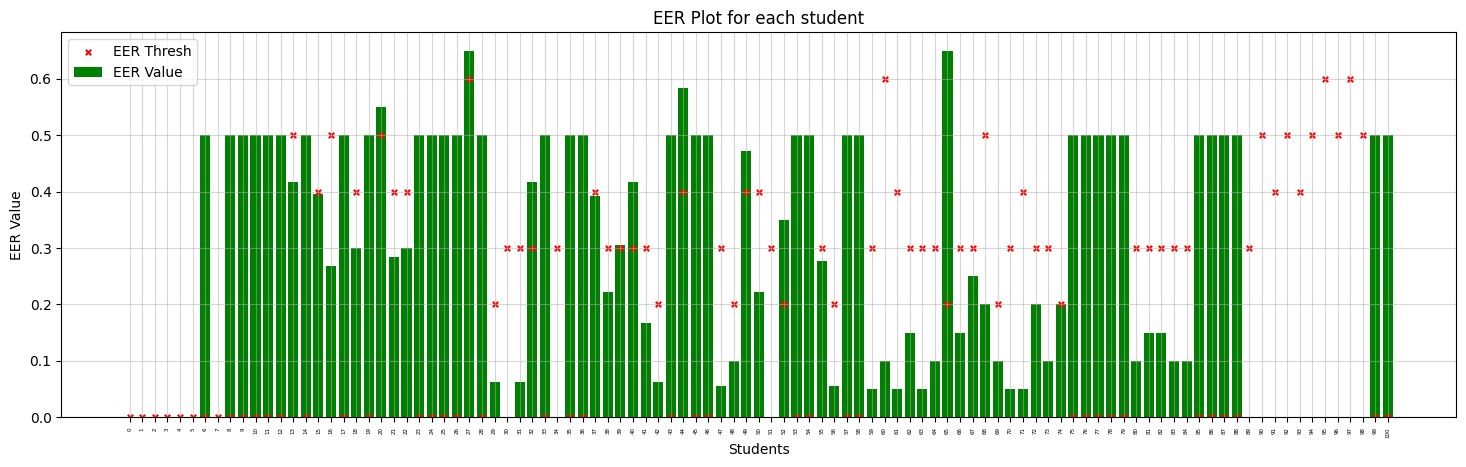

In [168]:
plt.figure(figsize=(18, 5))
plt.grid(alpha=0.5)
plt.bar(range(len(eer_thresh_list)), eer_list, color='g', label='EER Value')
plt.scatter(range(len(eer_thresh_list)), eer_thresh_list, color='red', s=15, marker='x', label='EER Thresh')
plt.xticks(range(len(eer_thresh_list)), rotation=90, fontsize=4)
# plt.scatter(range(len(eer_thresh_list)),eer_thresh_list)
plt.title("EER Plot for each student")
plt.ylabel("EER Value")
plt.xlabel("Students")
plt.legend()
plt.show()

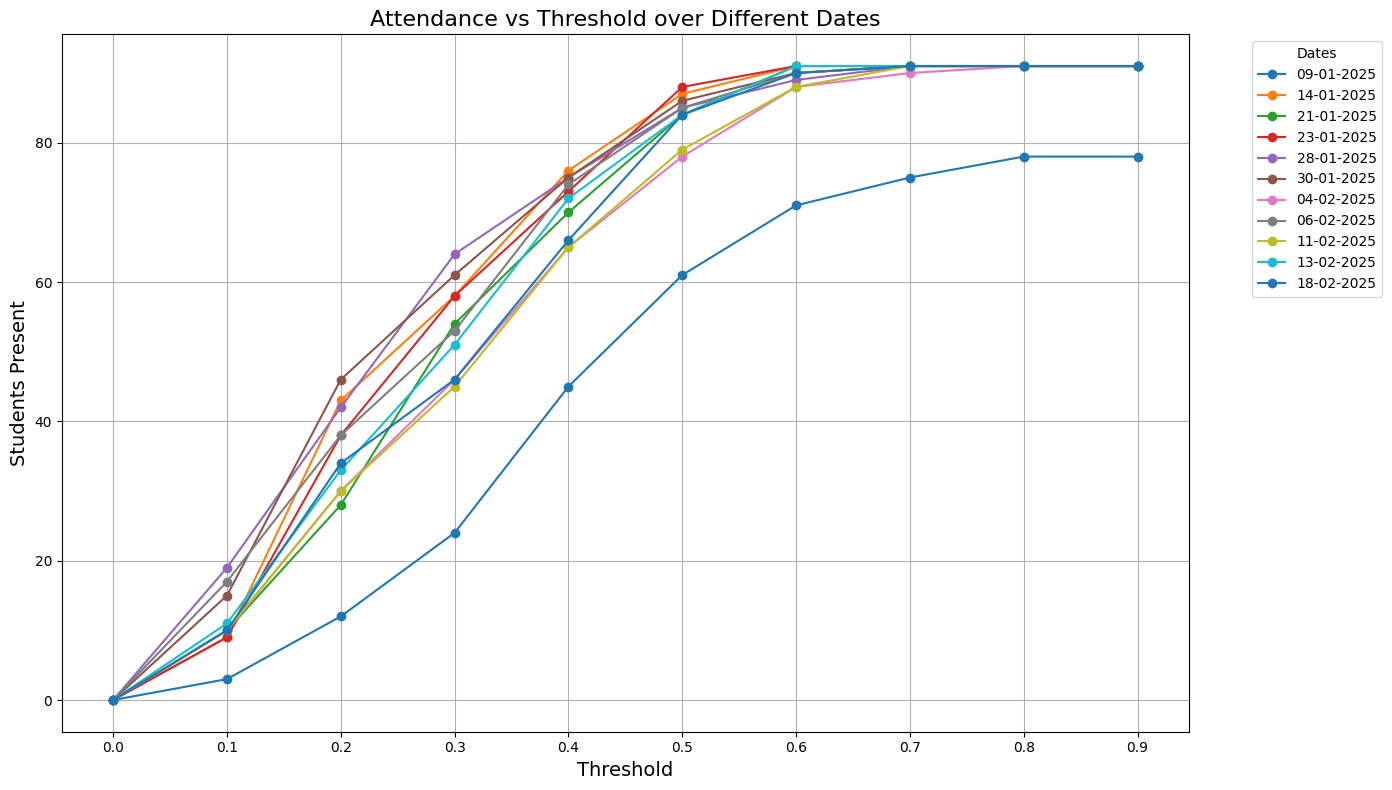

In [ ]:
import matplotlib.pyplot as plt

# Data
dates = ['09-01-2025', '14-01-2025', '21-01-2025', '23-01-2025', '28-01-2025', 
        '30-01-2025', '04-02-2025', '06-02-2025', '11-02-2025', '13-02-2025', '18-02-2025']

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

attendance_counts = {
    '09-01-2025': [0, 3, 12, 24, 45, 61, 71, 75, 78, 78],
    '14-01-2025': [0, 9, 43, 58, 76, 87, 91, 91, 91, 91],
    '21-01-2025': [0, 10, 28, 54, 70, 84, 91, 91, 91, 91],
    '23-01-2025': [0, 9, 38, 58, 73, 88, 91, 91, 91, 91],
    '28-01-2025': [0, 19, 42, 64, 75, 85, 89, 91, 91, 91],
    '30-01-2025': [0, 15, 46, 61, 75, 86, 90, 91, 91, 91],
    '04-02-2025': [0, 10, 30, 46, 65, 78, 88, 90, 91, 91],
    '06-02-2025': [0, 17, 38, 53, 74, 85, 90, 91, 91, 91],
    '11-02-2025': [0, 10, 30, 45, 65, 79, 88, 91, 91, 91],
    '13-02-2025': [0, 11, 33, 51, 72, 84, 91, 91, 91, 91],
    '18-02-2025': [0, 10, 34, 46, 66, 84, 90, 91, 91, 91],
}

# Plot
plt.figure(figsize=(14, 8))

for date in dates:
    plt.plot(thresholds, attendance_counts[date], marker='o', label=date)

plt.title('Attendance vs Threshold over Different Dates', fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Students Present', fontsize=14)
plt.xticks(thresholds)
plt.grid(True)
plt.legend(title='Dates', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
